# Statistical foundation of machine learning

In [32]:
import numpy as np
from prep import TimeWindowTransformer, LabelWindowExtractor

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

# adjust import if needed

## Loading raw data

In [33]:
# loading raw data
# PATH = f'/Users/marco/PROJECTS/data/'
PATH = r'C:\Users\gianm\Documents\Uni\Big Data\F422\project\data\\'
DATASET = 'guided' # change this to guided/freemoves if needed

X = np.load(PATH + f'{DATASET}/{DATASET}_dataset_X.npy')
Y = np.load(PATH + f'{DATASET}/{DATASET}_dataset_Y.npy')

## (Optional) Signal filtering

if you plan to filter your sEMG signals, it is recommended to perform
this preprocessing step directly on the continuous raw data prior to window extraction or feature
computation. Note that this step is completely optional but may improve your results.

## (0.5 point) Dataset preparation and augmentation through overlapping windows

You should first segment your sEMG signals into smaller windows of fixed size k = 500. These windows should be created with a chosen degree of overlap, which you can adjust based on the computational and memory resources available to you. Keep in mind that a larger overlap results in a greater number of samples and thus a larger dataset to train your models but to the cost of increasing computational demands.

### 
To prepare our dataset for regression tasks, we segment the continuous surface electromyography (sEMG) signals into smaller overlapping windows of fixed size. This preprocessing step is crucial as it enables the learning models to capture localized temporal patterns in muscle activity and link them to corresponding hand pose estimations.

We chose a **window size `k = 500` samples**, which corresponds to roughly **0.49 seconds** of sEMG data, given the sampling rate of **1024 Hz**. This window size strikes a balance between capturing enough signal dynamics and ensuring real-time usability for prosthesis control.

We implemented a **50% overlap**, meaning each window starts 250 samples after the previous one. This overlap increases the number of training samples without excessively inflating computational costs. Larger overlaps (e.g., 75%) generate even more samples but demand significantly more memory and processing time, which may not scale efficiently depending on available resources.

This approach is implemented using two custom transformer classes:
- `TimeWindowTransformer`: Applies sliding windows to the raw sEMG signals.
- `LabelWindowExtractor`: Aligns the corresponding joint angle labels by sampling at the end of each time window.

This transformation ensures consistent alignment between each input window and its output label, facilitating supervised learning.

In [34]:
# Define parameters
size = 500
step = 250

# Initialize transformers
tw_transformer = TimeWindowTransformer(size=size, step=step)
label_extractor = LabelWindowExtractor(size=size, step=step)

# Apply transformations
X_windows = tw_transformer.transform(X)     # shape: (5, n_windows, 8, 500)
Y_labels = label_extractor.transform(Y)     # shape: (5, n_windows, 51)

# Inspect shapes
print("X_windows shape:", X_windows.shape)
print("Y_labels shape:", Y_labels.shape)


X_windows shape: (5, 919, 8, 500)
Y_labels shape: (5, 919, 51)


## (1 point) Cross-validation strategy

Determine and implement an adequate cross-validation strategy to validate your regression models, specifying how you organized your data partitions for training and validation. Provide a detailed justification showing that your validation sets remain completely independent from the training set. Include reasoning or evidence demonstrating explicitly that your chosen partitioning strategy prevents data leakage or bias, ensuring the reliability and generalizability of your model performance estimates.

###
To rigorously evaluate the performance and generalization capabilities of our regression models, we implemented a **cross-validation strategy** that ensures independence between training and validation data and avoids data leakage.

The available data consists of 5 recording sessions. We use the first **4 sessions** (`X_train_val_folds`, `Y_train_val_folds`) for training and validation, and **reserve the 5th session** (`X_test`, `Y_test`) as a completely unseen test set. This separation allows us to simulate real-world scenarios where the model encounters entirely new data from the same participant.

In [35]:
X_train_val_folds = X_windows[:4]
Y_train_val_folds = Y_labels[:4]
X_test = X_windows[4]
Y_test = Y_labels[4]

Within the 4 training sessions, we assess the estimator performance using a by training it on 75% of the training set and evaluating it on the remaining 25%, representing a “holdout" portion of the data that the model has never seen. To prevent potential bias due to specificities in portions of the training set, we use a stratified **4-fold cross-validation** and report the root mean squared error (**RMSE**) and normalized mean squared error (**NMSE**) across all. This strategy ensures:

- **Complete independence** between training and validation data in each fold
- Robust estimation of the model's performance across different recording sessions
- Reduced risk of overfitting to session-specific artifacts

This strategy provides insights into how well the model generalizes to other sessions from the same participant. However, it does not provide any information on the estimator’s ability to generalize to data from different participants.

We implemented this strategy creating a 'cross_validate_pipeline' utility function to handle the fold-based evaluation of any sklearn-compatible pipeline:

- Trains on 3 sessions and validates on the 4th (rotating fold)
- Reports both training and validation scores for each fold
- Computes mean performance across all folds for better interpretability

## (3 points) Baseline approach

Create a custom class inheriting from scikit-learn’s `BaseEstimator`
and `TransformerMixin` that implements the extraction of common time-domain features described
in section 3.1. Note that the features described in Section 3.1 represent the minimal required set. We
encourage you to include additional features or preprocessing steps if you would like to further improve your model performances. Select at least two different regression models, compare their cross-validated performance, and evaluate their feature importances. For both models, perform feature selection to determine the optimal subset of features minimizing the Root Mean Squared Error (RMSE).
Clearly document this process in your notebook, discussing the outcomes in detail. Finally, create a
scikit-learn `Pipeline` that integrates your custom feature extraction class, the optimal feature selection step, and the best-performing regression model identified from your cross-validation results.
Using visualizations and tables to illustrate your findings, and employing formulas or pseudo-code
to explain the feature selection procedure, is strongly encouraged. Note that one-third of the score
will depend on the quality and clarity of your documentation.

###
To establish a robust performance benchmark, we designed a baseline approach that uses standard time-domain features extracted from the raw sEMG signal windows. These features have been widely used in EMG-based regression problems due to their low computational cost and effectiveness in capturing muscle activity dynamics.

We created a custom class `TimeDomainTransformer`, inheriting from `BaseEstimator` and `TransformerMixin`, to extract 12 key time-domain features from each EMG channel over a signal window of 500 samples.
These features are computed along the time dimension and include:

- **MAV** – Mean Absolute Value
- **RMS** – Root Mean Square
- **VAR** – Variance
- **STD** – Standard Deviation
- **ZC** – Zero Crossing Count
- **MPR** – Myopulse Percentage Rate (using a tunable threshold `sigma_mpr`)
- **MAA** – Maximum Absolute Amplitude
- **WL** – Waveform Length
- **SSC** – Slope Sign Changes
- **WA** – Wilson Amplitude
- **MFL** – Maximum Fractal Length
- **KRT** – Kurtosis

Each channel of the EMG window (8 in total) produces 12 features, resulting in a final feature vector of size **96** per window.

We constructed three baseline pipelines using different regression algorithms to evaluate how well standard time-domain features can predict hand articulation from sEMG signals.

Each pipeline follows the same general structure:

1. **Feature Extraction**  
   Extracts 12 physiological descriptors from each EMG channel using the custom `TimeDomainTransformer`.

2. **Standardization**  
   Normalizes the extracted features using `StandardScaler` to ensure each feature contributes equally to the regression model.

3. **Regression Model**  
   Each pipeline uses a different learning algorithm:
   - **Kernel Ridge Regression** with a Laplacian kernel
   - **K-Nearest Neighbors Regression**
   - **Random Forest Regression**

To improve the performance of each baseline model, we performed **manual hyperparameter tuning** using an exhaustive grid search strategy. This process is implemented in a dedicated notebook, `tuning_baseline.ipynb`, and applied independently to each pipeline.

For each model, we defined a tailored parameter grid and evaluated all combinations using our cross-validation procedure. The objective is to identify the configuration that minimizes the **validation RMSE**, while also tracking **NMSE** for robustness.

Below is a summary of the parameter grids explored:

- **Time Domain Features + Kernel Ridge**
  - `alpha`: regularization strength
  - `gamma`: kernel coefficient
  - `kernel`: type of kernel (`rbf`, `laplacian`, `poly`)

- **Time Domain Features + KNN**
  - `n_neighbors`: number of nearest neighbors
  - `weights`: uniform or distance-based weighting

- **Time Domain Features + Random Forest**
  - `n_estimators`: number of trees in the forest
  - `max_depth`: depth of each tree
  - `min_samples_split`: minimum samples required to split a node
  - `min_samples_leaf`: minimum samples at a leaf node

Each model is tuned using the following loop:

```python
for model_name, pipeline in models.items():
    print(f"\nTuning Model: {model_name}") 
    results = []

    for params in ParameterGrid(param_grids[model_name]):
        pipeline.set_params(**params)
        scores = cross_validate_pipeline(pipeline, X_train_val_folds, Y_train_val_folds, metric_fns)

        results.append({
            'params': params,
            'mean_train_RMSE': scores['avg_train_RMSE'],
            'mean_val_RMSE': scores['avg_val_RMSE'],
            'mean_train_NMSE': scores['avg_train_NMSE'],
            'mean_val_NMSE': scores['avg_val_NMSE']
        })

    all_results[model_name] = results
```

The results are saved in a seperate json file, allowing us to later analyze the best hyperparameter configuration per model. This tuning step ensures that our baselines are not only functional but also reasonably optimized for performance.

> **DISCLAIMER**

All models and pipelines developed in this project adhere to the following input/output shape requirements to ensure compatibility with the dataset and evaluation routines:

- `model.fit(X, y)`  
  - **Input:**  
    - `X`: NumPy array of shape **(N, 8, 500)** — N windows of raw sEMG signals (8 channels, 500 samples each)  
    - `y`: NumPy array of shape **(N, 51)** — Corresponding joint-angle labels
  - **Note:** This method fits the model in place; the return value is not used.

- `model.predict(X)`  
  - **Input:** `X` of shape **(N, 8, 500)**  
  - **Output:** NumPy array of shape **(N, 51)** — Predicted joint angles

Custom transformers (e.g., for feature extraction) should implement the `fit_transform()` method:
- **Input:** `X` of shape **(N, 8, 500)**
- **Output:** Transformed feature array of shape **(N, ...)**, depending on the specific transformer logic

#### Baseline models - guided

In [36]:
from prep import TimeDomainTransformer

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge

from validation import RMSE, NMSE, cross_validate_pipeline

In [37]:
baseline1 = Pipeline(
    [
        ('feature_extraction', TimeDomainTransformer(sigma_mpr=0.3)),
        ('scaler', StandardScaler()),
        ('regressor', KernelRidge(
            alpha = 0.001,
            kernel='laplacian'))
    ]
)

baseline2 = Pipeline(
    [
        ('feature_extraction', TimeDomainTransformer(sigma_mpr=0.3)),
        ('scaler', StandardScaler()),
        ('regressor', KNeighborsRegressor())
    ]
)

baseline3 = Pipeline(
    [
        ('feature_extraction', TimeDomainTransformer()),
        ('scaler', StandardScaler()),
        ('regressor', RandomForestRegressor())
    ]
)

To evaluate these baselines, we applied the **4-fold cross-validation** strategy described previously. For each model, we report both:

- **Root Mean Squared Error (RMSE)**: Measures the average magnitude of prediction errors.
- **Normalized Mean Squared Error (NMSE)**: Indicates performance relative to the variance of the true joint angles.

This setup allows us to compare model performance on a consistent, unbiased basis and analyze the robustness of each approach.

In [9]:
# Evaluation
metric_fns = {'RMSE': RMSE, 'NMSE': NMSE}
models = {
    'Time domain features + Kernel Ridge': baseline1,
    'Time domain features + KNN': baseline2,
    'Time domain features + Random Forests': baseline3
}

for model_name, model in models.items():
    print(f'\nModel: {model_name}')
    result = cross_validate_pipeline(model, X_train_val_folds, Y_train_val_folds, metric_fns, verbose=1)



Model: Time domain features + Kernel Ridge

Average Scores across folds:
RMSE: train=0.0181, val=5.1703
NMSE: train=0.0000, val=0.1351

Model: Time domain features + KNN

Average Scores across folds:
RMSE: train=2.0971, val=4.7569
NMSE: train=0.0219, val=0.1144

Model: Time domain features + Random Forests

Average Scores across folds:
RMSE: train=1.1835, val=5.1831
NMSE: train=0.0070, val=0.1388


#### Features selection

In [85]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# Assume NMSE is already defined somewhere
metric_fns = {'NMSE': NMSE}

# Feature extraction
n_sessions, n_windows, n_channels, window_size = X_train_val_folds.shape
X_flat = X_train_val_folds.reshape(-1, n_channels, window_size)
Y_flat = Y_train_val_folds.reshape(-1, Y_train_val_folds.shape[-1])

# Apply time-domain transformer
td_transformer = TimeDomainTransformer()
X_feat = td_transformer.transform(X_flat).reshape(X_flat.shape[0], -1)
n_features = X_feat.shape[1]

# Compute correlation matrix
corr_matrix = np.abs(np.corrcoef(X_feat.T, Y_flat.T)[:n_features, n_features:])
feature_scores = np.mean(corr_matrix, axis=1)
ranking_idx = np.argsort(feature_scores)[::-1]

# Rank features
X_df = pd.DataFrame(X_feat)
ranking_multi_corr_idx = X_df.columns[ranking_idx].tolist()

# Prepare data for session-wise CV
X_sessions = td_transformer.transform(X_train_val_folds).reshape(n_sessions, n_windows, -1)
Y_sessions = Y_train_val_folds[:, :, 0]  # single-joint output for evaluation

# Cross-validation for each number of features
CV_err_multi_corr = np.zeros((n_features, 4))

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_indices):
        self.feature_indices = feature_indices

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # X shape: (samples, n_features) or (sessions, windows, n_features)
        if X.ndim == 3:  # if shape (sessions, windows, features)
            X = X.reshape(-1, X.shape[-1])  # flatten to (samples, features)
        return X[:, self.feature_indices]

for nb_features in range(1, n_features + 1):
    selected_indices = ranking_idx[:nb_features]

    pipeline = Pipeline([
        ('select', FeatureSelector(selected_indices)),
        ('reg', KernelRidge())
    ])

    cv_results = cross_validate_pipeline(
        pipeline,
        X_sessions,
        Y_sessions,
        metric_fns=metric_fns,
        n_folds=n_sessions,
        verbose=0
    )
    CV_err_multi_corr[nb_features - 1, :] = [
        cv_results[i]['val_NMSE'] for i in range(n_sessions)
    ]

# Output results
print("\nMulti-Output Correlation Ranking (Session-based CV)")
for i in range(n_features):
    print(f"#Features: {i+1}; CV error = {CV_err_multi_corr[i,:].mean():.4f}; std dev = {CV_err_multi_corr[i,:].std():.4f}")


Multi-Output Correlation Ranking (Session-based CV)
#Features: 1; CV error = 1.0565; std dev = 0.1566
#Features: 2; CV error = 0.6918; std dev = 0.0243
#Features: 3; CV error = 0.6866; std dev = 0.0230
#Features: 4; CV error = 0.6899; std dev = 0.0229
#Features: 5; CV error = 0.6911; std dev = 0.0246
#Features: 6; CV error = 0.6991; std dev = 0.0286
#Features: 7; CV error = 0.6578; std dev = 0.0196
#Features: 8; CV error = 0.6586; std dev = 0.0197
#Features: 9; CV error = 0.6491; std dev = 0.0175
#Features: 10; CV error = 0.6511; std dev = 0.0192
#Features: 11; CV error = 0.6487; std dev = 0.0215
#Features: 12; CV error = 0.6475; std dev = 0.0214
#Features: 13; CV error = 0.6470; std dev = 0.0214
#Features: 14; CV error = 0.6494; std dev = 0.0219
#Features: 15; CV error = 0.6540; std dev = 0.0306
#Features: 16; CV error = 0.6529; std dev = 0.0273
#Features: 17; CV error = 0.6495; std dev = 0.0258
#Features: 18; CV error = 0.6484; std dev = 0.0259
#Features: 19; CV error = 0.6491; std 

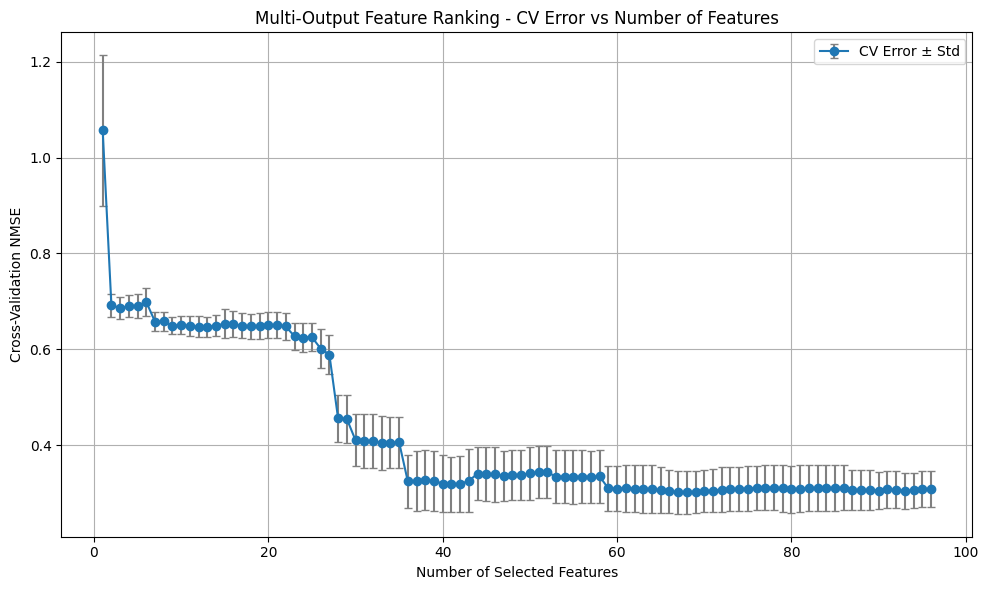

In [51]:
import matplotlib.pyplot as plt

# Compute mean and std dev of CV error for each number of features
mean_errors = CV_err_multi_corr.mean(axis=1)
std_errors = CV_err_multi_corr.std(axis=1)
feature_counts = np.arange(1, n_features + 1)

# Plot
plt.figure(figsize=(10, 6))
plt.errorbar(feature_counts, mean_errors, yerr=std_errors, fmt='-o', ecolor='gray', capsize=3, label='CV Error ± Std')
plt.xlabel('Number of Selected Features')
plt.ylabel('Cross-Validation NMSE')
plt.title('Multi-Output Feature Ranking - CV Error vs Number of Features')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [52]:
td_feature_names = ['MAV', 'RMS', 'VAR', 'STD', 'ZC', 'MPR',
                    'MAA', 'WL', 'SSC', 'WA', 'MFL', 'KRT']
n_td_features = len(td_feature_names)
n_channels = X_flat.shape[1]

# Initialize a dict to hold total relevance score per feature type
td_feature_relevance = {name: 0.0 for name in td_feature_names}
td_feature_counts = {name: 0 for name in td_feature_names}

# Aggregate feature relevance by type
for feat_idx, score in enumerate(feature_scores):
    td_feat_type_idx = feat_idx % n_td_features
    td_feat_name = td_feature_names[td_feat_type_idx]
    td_feature_relevance[td_feat_name] += score
    td_feature_counts[td_feat_name] += 1

# Average relevance per feature type
td_feature_avg_relevance = {
    k: td_feature_relevance[k] / td_feature_counts[k]
    for k in td_feature_names
}

# Sort and print
sorted_relevance = sorted(td_feature_avg_relevance.items(), key=lambda x: x[1], reverse=True)
print("\nAverage Feature Relevance by Time-Domain Feature Type:")
for feat_name, avg_score in sorted_relevance:
    print(f"{feat_name}: {avg_score:.4f}")


Average Feature Relevance by Time-Domain Feature Type:
MFL: 0.2791
SSC: 0.2572
WL: 0.2529
MAV: 0.2524
MPR: 0.2503
STD: 0.2321
RMS: 0.2321
ZC: 0.1977
MAA: 0.1949
WA: 0.1871
VAR: 0.1730
KRT: 0.0977


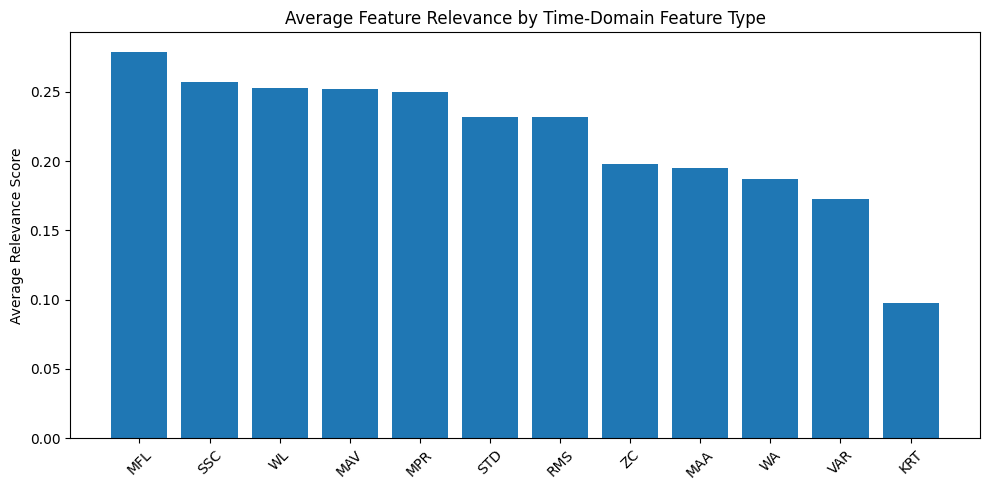

In [46]:
labels, scores = zip(*sorted_relevance)

plt.figure(figsize=(10, 5))
plt.bar(labels, scores)
plt.ylabel('Average Relevance Score')
plt.title('Average Feature Relevance by Time-Domain Feature Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Average NRMSE Reduction by Time-Domain Feature Type:
MFL: 0.063385
MAV: 0.016411
STD: 0.008312
SSC: 0.004422
ZC: 0.001591
MPR: 0.001233
RMS: 0.000555
MAA: 0.000100
KRT: 0.000072
WL: -0.000642
WA: -0.000940
VAR: -0.001077


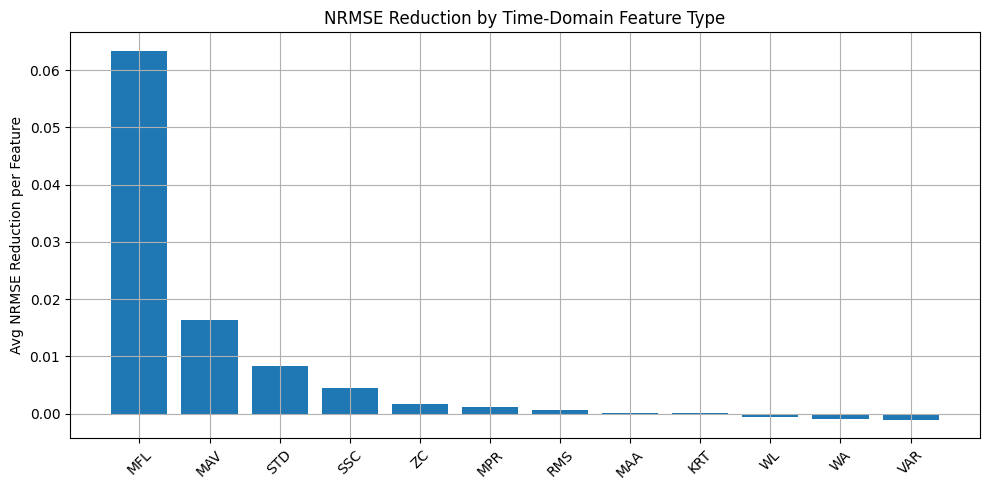

In [53]:
# Map: feature index → time-domain feature type
feature_idx_to_td_type = {
    idx: td_feature_names[idx % n_td_features]
    for idx in range(n_features)
}

# Calculate average NRMSE over folds
mean_nrmse = CV_err_multi_corr.mean(axis=1)  # shape: (n_features,)

# Compute NRMSE reduction per feature added (delta from previous)
nrmse_deltas = np.zeros(n_features)
nrmse_deltas[0] = 0  # First feature has no previous
for i in range(1, n_features):
    nrmse_deltas[i] = mean_nrmse[i - 1] - mean_nrmse[i]

# Assign delta improvement to the feature type of the i-th added feature
td_feature_impact = {name: 0.0 for name in td_feature_names}
td_feature_counts = {name: 0 for name in td_feature_names}

for i, feat_col in enumerate(ranking_multi_corr_idx):
    feat_idx = int(feat_col)  # DataFrame columns are integer-indexed
    td_type = feature_idx_to_td_type[feat_idx]
    td_feature_impact[td_type] += nrmse_deltas[i]
    td_feature_counts[td_type] += 1

# Normalize by count to get average contribution
td_feature_avg_impact = {
    k: td_feature_impact[k] / td_feature_counts[k]
    for k in td_feature_names if td_feature_counts[k] > 0
}
# Sort by contribution
sorted_impact = sorted(td_feature_avg_impact.items(), key=lambda x: x[1], reverse=True)

print("\nAverage NRMSE Reduction by Time-Domain Feature Type:")
for td_type, impact in sorted_impact:
    print(f"{td_type}: {impact:.6f}")

labels, values = zip(*sorted_impact)
plt.figure(figsize=(10, 5))
plt.bar(labels, values)
plt.ylabel('Avg NRMSE Reduction per Feature')
plt.title('NRMSE Reduction by Time-Domain Feature Type')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\gianm\AppData\Local\Temp\ipykernel_31272\2449098312.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_types))


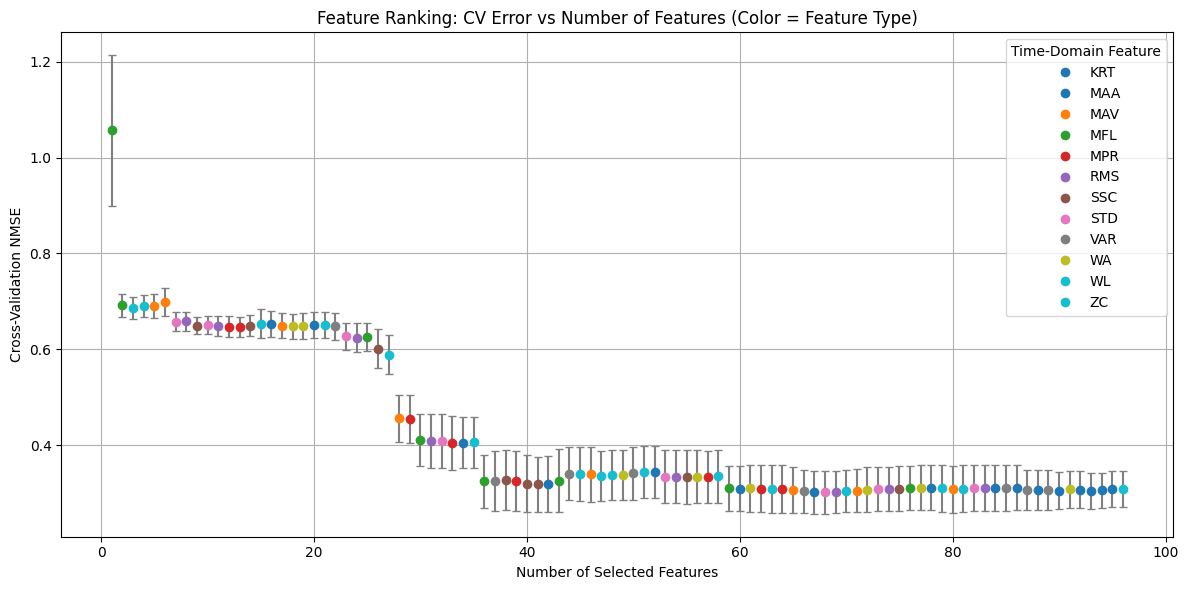

In [54]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Setup
td_feature_names = ['MAV', 'RMS', 'VAR', 'STD', 'ZC', 'MPR',
                    'MAA', 'WL', 'SSC', 'WA', 'MFL', 'KRT']
n_td_features = len(td_feature_names)

# Get number of channels
n_channels = X_flat.shape[1]

# Map each feature index to its time-domain feature name
feature_idx_to_td_type = {
    idx: td_feature_names[idx % n_td_features]
    for idx in range(n_features)
}

# Get feature types in order of feature ranking
feature_types_ranked = [feature_idx_to_td_type[int(feat)] for feat in ranking_multi_corr_idx]

# Compute CV error stats
mean_errors = CV_err_multi_corr.mean(axis=1)
std_errors = CV_err_multi_corr.std(axis=1)
feature_counts = np.arange(1, n_features + 1)

# Assign colors
unique_types = sorted(set(feature_types_ranked))
cmap = cm.get_cmap('tab10', len(unique_types))
type_to_color = {td_type: cmap(i) for i, td_type in enumerate(unique_types)}

# Plot each feature increment as a colored dot
plt.figure(figsize=(12, 6))
for i in range(n_features):
    td_type = feature_types_ranked[i]
    plt.errorbar(feature_counts[i], mean_errors[i],
                 yerr=std_errors[i],
                 fmt='o', color=type_to_color[td_type],
                 ecolor='gray', capsize=3)

# Add legend manually
for td_type in unique_types:
    plt.plot([], [], 'o', color=type_to_color[td_type], label=td_type)

plt.xlabel('Number of Selected Features')
plt.ylabel('Cross-Validation NMSE')
plt.title('Feature Ranking: CV Error vs Number of Features (Color = Feature Type)')
plt.grid(True)
plt.legend(title='Time-Domain Feature')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

# Define mutual info via correlation
def mutual_info_corr(X, Y):
    c = np.corrcoef(X, Y)[0,1]
    if abs(c) == 1:
        c = 0.999999
    return -0.5 * np.log(1 - c**2)

def compute_mi_vector(X_tr, Y_tr):
    mis = []
    for col in X_tr.columns:
        mi_vals = []
        for j in range(Y_tr.shape[1]):
            mi_vals.append(mutual_info_corr(X_tr[col].values, Y_tr[:, j]))
        mis.append(np.mean(mi_vals))  # average across joints
    return np.array(mis)

# Feature selector for pipeline
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_indices):
        self.feature_indices = feature_indices
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if X.ndim == 3:  # (sessions, windows, features)
            X = X.reshape(-1, X.shape[-1])
        return X[:, self.feature_indices]

# Extract features
n_sessions, n_windows, n_channels, window_size = X_train_val_folds.shape
X_flat = X_train_val_folds.reshape(-1, n_channels, window_size)
td_transformer = TimeDomainTransformer()
X_feat = td_transformer.transform(X_flat).reshape(X_flat.shape[0], -1)
n_features = X_feat.shape[1]

# Reorganize back into session-wise structure
X_sessions = td_transformer.transform(X_train_val_folds).reshape(n_sessions, n_windows, -1)
Y_sessions = Y_train_val_folds  # shape: (sessions, windows, 51)

# Flatten for computing mRMR scores globally
X_all = X_sessions.reshape(-1, X_sessions.shape[-1])
Y_all = Y_sessions.reshape(-1, Y_sessions.shape[-1])
X_df = pd.DataFrame(X_all)

# mRMR selection
mutual_info_values = compute_mi_vector(X_df, Y_all)
selected = []
candidates = list(range(n_features))

for j in range(n_features):
    redundancy_score = np.zeros(len(candidates))
    if len(selected) > 0:
        for cidx in candidates:
            col_c = X_df.iloc[:, cidx]
            mis_c = []
            for sidx in selected:
                col_s = X_df.iloc[:, sidx]
                cc = np.corrcoef(col_s, col_c)[0,1]
                if abs(cc) == 1:
                    cc = 0.999999
                mis_c.append(-0.5 * np.log(1 - cc**2))
            redundancy_score[candidates.index(cidx)] = np.mean(mis_c)
    mRMR_score = mutual_info_values[candidates] - redundancy_score
    best_idx = candidates[np.argmax(mRMR_score)]
    selected.append(best_idx)
    candidates.remove(best_idx)

# Evaluate mRMR ranking using cross_validate_pipeline
CV_err_mrmr = np.zeros((n_features, n_sessions))

for nb_features in range(1, n_features + 1):
    selected_indices = selected[:nb_features]
    
    pipeline = Pipeline([
        ('select', FeatureSelector(selected_indices)),
        ('scale', StandardScaler()),
        ('reg', KernelRidge())
    ])

    metric_fns = {'NMSE': NMSE}

    cv_results = cross_validate_pipeline(
        pipeline,
        X_sessions,
        Y_sessions,
        metric_fns=metric_fns,
        n_folds=n_sessions,
        verbose=0
    )

    for fold_id in range(n_sessions):
        CV_err_mrmr[nb_features - 1, fold_id] = cv_results[fold_id]['val_NMSE']

# Report results
print("\nmRMR Feature Selection with Multi-Output Regression")
for i in range(n_features):
    print(f"#Features: {i+1}; CV error = {CV_err_mrmr[i,:].mean():.4f}; std dev = {CV_err_mrmr[i,:].std():.4f}")

print("\nSelected feature ranking (by column index):")
print(selected)



mRMR Feature Selection with Multi-Output Regression
#Features: 1; CV error = 2.2197; std dev = 0.1247
#Features: 2; CV error = 2.0853; std dev = 0.1877
#Features: 3; CV error = 2.0789; std dev = 0.2091
#Features: 4; CV error = 2.0217; std dev = 0.1111
#Features: 5; CV error = 2.0128; std dev = 0.1060
#Features: 6; CV error = 2.0097; std dev = 0.1073
#Features: 7; CV error = 2.0129; std dev = 0.1382
#Features: 8; CV error = 2.0008; std dev = 0.1354
#Features: 9; CV error = 1.9875; std dev = 0.1363
#Features: 10; CV error = 1.9774; std dev = 0.1238
#Features: 11; CV error = 1.9801; std dev = 0.1226
#Features: 12; CV error = 1.9648; std dev = 0.1197
#Features: 13; CV error = 1.9466; std dev = 0.1123
#Features: 14; CV error = 1.9314; std dev = 0.1095
#Features: 15; CV error = 1.9308; std dev = 0.1085
#Features: 16; CV error = 1.8454; std dev = 0.1545
#Features: 17; CV error = 1.8458; std dev = 0.1545
#Features: 18; CV error = 1.8451; std dev = 0.1541
#Features: 19; CV error = 1.8353; std 

C:\Users\gianm\AppData\Local\Temp\ipykernel_31272\4059443868.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_types))


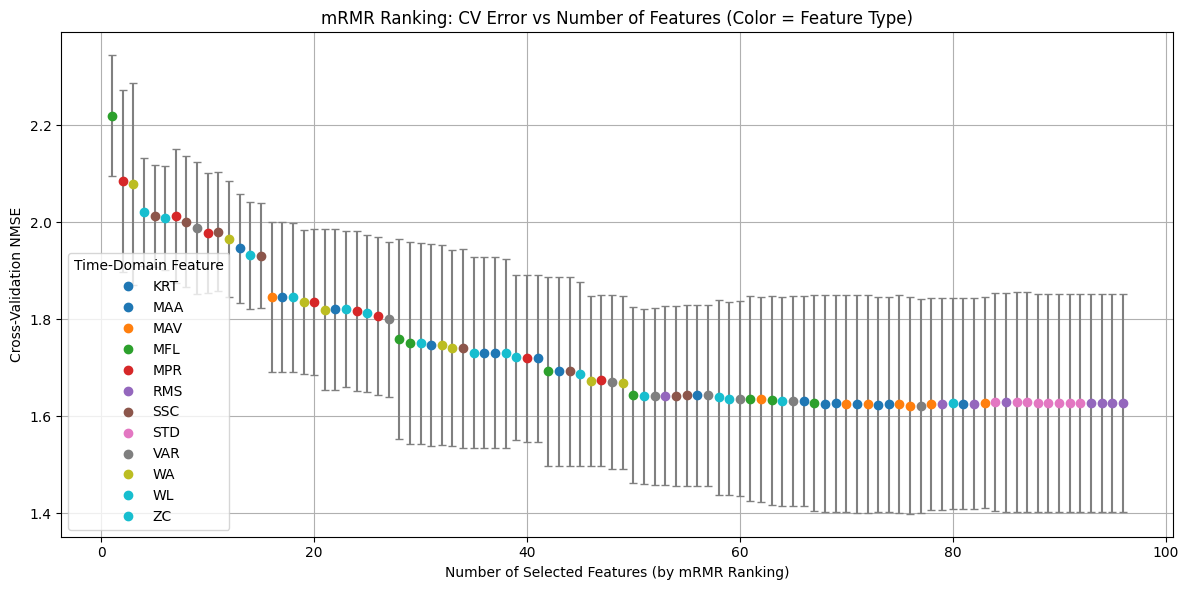

In [63]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Reuse from earlier
td_feature_names = ['MAV', 'RMS', 'VAR', 'STD', 'ZC', 'MPR',
                    'MAA', 'WL', 'SSC', 'WA', 'MFL', 'KRT']
n_td_features = len(td_feature_names)
n_channels = 8  # or X_flat.shape[1]
n_features = n_td_features * n_channels

# Map: feature index → time-domain type
feature_idx_to_td_type = {
    idx: td_feature_names[idx % n_td_features]
    for idx in range(n_features)
}

# Get feature types for mRMR ranking
feature_types_ranked = [feature_idx_to_td_type[idx] for idx in selected]

# Compute stats
mean_errors = CV_err_mrmr.mean(axis=1)
std_errors = CV_err_mrmr.std(axis=1)
feature_counts = np.arange(1, n_features + 1)

# Color setup
unique_types = sorted(set(feature_types_ranked))
cmap = cm.get_cmap('tab10', len(unique_types))
type_to_color = {td_type: cmap(i) for i, td_type in enumerate(unique_types)}

# Plot
plt.figure(figsize=(12, 6))
for i in range(n_features):
    td_type = feature_types_ranked[i]
    plt.errorbar(feature_counts[i], mean_errors[i],
                 yerr=std_errors[i],
                 fmt='o', color=type_to_color[td_type],
                 ecolor='gray', capsize=3)

# Legend
for td_type in unique_types:
    plt.plot([], [], 'o', color=type_to_color[td_type], label=td_type)

plt.xlabel('Number of Selected Features (by mRMR Ranking)')
plt.ylabel('Cross-Validation NMSE')
plt.title('mRMR Ranking: CV Error vs Number of Features (Color = Feature Type)')
plt.grid(True)
plt.legend(title='Time-Domain Feature')
plt.tight_layout()
plt.show()


Average NRMSE Reduction by Time-Domain Feature Type (from mRMR):
MPR: 0.019323
MFL: 0.013195
MAV: 0.010415
ZC: 0.009731
WA: 0.008289
WL: 0.004879
VAR: 0.002959
KRT: 0.002603
SSC: 0.002474
MAA: 0.000265
STD: -0.000049
RMS: -0.000067


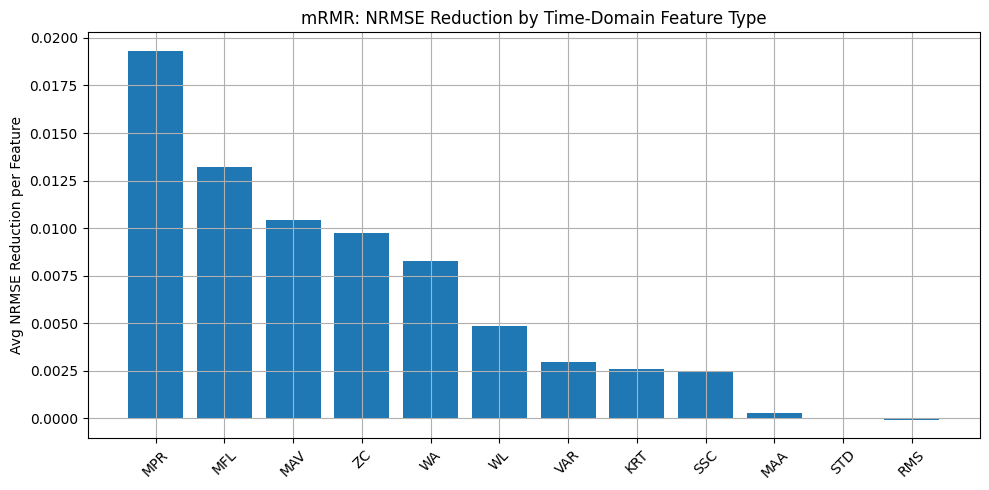

In [64]:
# Reuse from earlier
td_feature_names = ['MAV', 'RMS', 'VAR', 'STD', 'ZC', 'MPR',
                    'MAA', 'WL', 'SSC', 'WA', 'MFL', 'KRT']
n_td_features = len(td_feature_names)
n_channels = 8
n_features = n_channels * n_td_features

# Map index → feature type
feature_idx_to_td_type = {
    idx: td_feature_names[idx % n_td_features]
    for idx in range(n_features)
}

# Compute mean NRMSE across folds
mean_nrmse = CV_err_mrmr.mean(axis=1)  # shape: (n_features,)

# Compute delta NRMSE (reduction from previous feature)
nrmse_deltas = np.zeros(n_features)
nrmse_deltas[0] = 0  # no previous feature
for i in range(1, n_features):
    nrmse_deltas[i] = mean_nrmse[i - 1] - mean_nrmse[i]

# Accumulate deltas by feature type based on mRMR ranking
td_feature_impact = {name: 0.0 for name in td_feature_names}
td_feature_counts = {name: 0 for name in td_feature_names}

for i, feat_idx in enumerate(selected):  # selected is mRMR ranking
    td_type = feature_idx_to_td_type[feat_idx]
    td_feature_impact[td_type] += nrmse_deltas[i]
    td_feature_counts[td_type] += 1

# Normalize to get average per feature
td_feature_avg_impact = {
    k: td_feature_impact[k] / td_feature_counts[k]
    for k in td_feature_names if td_feature_counts[k] > 0
}

# Sort for visualization
sorted_impact = sorted(td_feature_avg_impact.items(), key=lambda x: x[1], reverse=True)

# Print
print("\nAverage NRMSE Reduction by Time-Domain Feature Type (from mRMR):")
for td_type, impact in sorted_impact:
    print(f"{td_type}: {impact:.6f}")

labels, values = zip(*sorted_impact)
plt.figure(figsize=(10, 5))
plt.bar(labels, values)
plt.ylabel('Avg NRMSE Reduction per Feature')
plt.title('mRMR: NRMSE Reduction by Time-Domain Feature Type')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Selected metric: MFL (score = 0.0600)
Selected metric: KRT (score = -0.0289)
Selected metric: SSC (score = -0.0049)
Selected metric: ZC (score = -0.0185)
Selected metric: WA (score = -0.0262)
Selected metric: MPR (score = -0.0219)
Selected metric: VAR (score = -0.0274)
Selected metric: WL (score = -0.0541)
Selected metric: MAA (score = -0.0872)
Selected metric: MAV (score = -0.1074)
Selected metric: RMS (score = -0.1396)
Selected metric: STD (score = -0.2153)


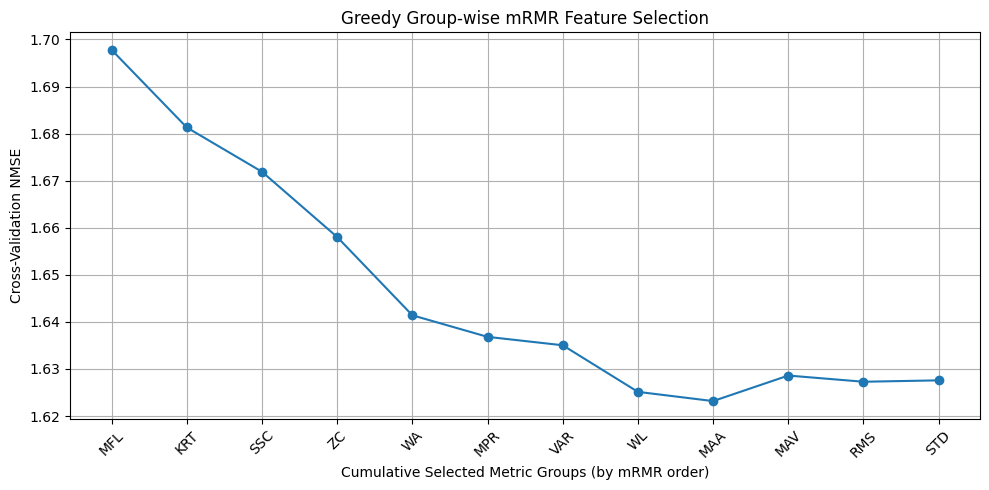

In [80]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Utility Functions

def mutual_info_corr(X, Y):
    c = np.corrcoef(X, Y)[0,1]
    if abs(c) == 1:
        c = 0.999999
    return -0.5 * np.log(1 - c**2)

def compute_avg_relevance(X_group, Y_all):
    mi_vals = []
    for col in X_group.columns:
        for j in range(Y_all.shape[1]):
            mi_vals.append(mutual_info_corr(X_group[col].values, Y_all[:, j]))
    return np.mean(mi_vals)

def compute_avg_redundancy(X_group, X_selected):
    if X_selected.shape[1] == 0:
        return 0.0
    mi_vals = []
    for col_c in X_group.columns:
        for col_s in X_selected.columns:
            cc = np.corrcoef(X_group[col_c].values, X_selected[col_s].values)[0,1]
            if abs(cc) == 1:
                cc = 0.999999
            mi_vals.append(-0.5 * np.log(1 - cc**2))
    return np.mean(mi_vals)

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_indices):
        self.feature_indices = feature_indices
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if X.ndim == 3:
            X = X.reshape(-1, X.shape[-1])
        return X[:, self.feature_indices]

# Feature Extraction
td_feature_names = ['MAV', 'RMS', 'VAR', 'STD', 'ZC', 'MPR',
                    'MAA', 'WL', 'SSC', 'WA', 'MFL', 'KRT']
n_td_features = len(td_feature_names)
n_sessions, n_windows, n_channels, window_size = X_train_val_folds.shape
n_features = n_channels * n_td_features

# Apply time-domain features
X_flat = X_train_val_folds.reshape(-1, n_channels, window_size)  # (4595, 8, 500)
td_transformer = TimeDomainTransformer()
X_feat = td_transformer.transform(X_flat).reshape(-1, n_features)  # (4595, 96)

# Restore to per-session structure
X_sessions = X_feat.reshape(n_sessions, n_windows, n_features)
Y_sessions = Y_train_val_folds
X_all = X_sessions.reshape(-1, n_features)
Y_all = Y_sessions.reshape(-1, Y_sessions.shape[-1])
X_df = pd.DataFrame(X_all)

# Define metric groups (8 features per metric)
metric_to_indices = {
    metric: [i for i in range(n_features) if i % n_td_features == td_feature_names.index(metric)]
    for metric in td_feature_names
}

remaining_metrics = list(td_feature_names)
selected_metrics = []
selected_feature_indices = []
CV_err_mrmr_group = []

# Greedy mRMR selection per metric group

while remaining_metrics:
    best_metric = None
    best_score = -np.inf

    for metric in remaining_metrics:
        candidate_indices = metric_to_indices[metric]
        X_group = X_df.iloc[:, candidate_indices]
        X_sel = X_df.iloc[:, selected_feature_indices] if selected_feature_indices else pd.DataFrame(np.empty((X_df.shape[0], 0)))

        relevance = compute_avg_relevance(X_group, Y_all)
        redundancy = compute_avg_redundancy(X_group, X_sel)
        mrmr_score = relevance - redundancy

        if mrmr_score > best_score:
            best_score = mrmr_score
            best_metric = metric

    # Add best metric group
    print(f"Selected metric: {best_metric} (score = {best_score:.4f})")
    selected_metrics.append(best_metric)
    selected_feature_indices.extend(metric_to_indices[best_metric])
    remaining_metrics.remove(best_metric)

    # Evaluate with cross_validate_pipeline
    pipeline = Pipeline([
        ('select', FeatureSelector(selected_feature_indices)),
        ('scale', StandardScaler()),
        ('reg', KernelRidge())
    ])
    metric_fns = {'NMSE': NMSE}
    results = cross_validate_pipeline(
        pipeline,
        X_sessions,
        Y_sessions,
        metric_fns=metric_fns,
        n_folds=X_sessions.shape[0],
        verbose=0
    )
    CV_err_mrmr_group.append(results['avg_val_NMSE'])

# Plot performance

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(CV_err_mrmr_group) + 1), CV_err_mrmr_group, marker='o')
plt.xticks(range(1, len(selected_metrics) + 1), selected_metrics, rotation=45)
plt.xlabel("Cumulative Selected Metric Groups (by mRMR order)")
plt.ylabel("Cross-Validation NMSE")
plt.title("Greedy Group-wise mRMR Feature Selection")
plt.grid(True)
plt.tight_layout()
plt.show()

In [81]:
# PCA - produces unstructured components (not original features)
from sklearn.decomposition import PCA

# Custom selector to keep first k PCA components
class PCAReducer(BaseEstimator, TransformerMixin):
    def __init__(self, n_components):
        self.n_components = n_components
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if X.ndim == 3:
            X = X.reshape(-1, X.shape[-1])
        return X[:, :self.n_components]

# Flatten and extract features
n_sessions, n_windows, n_channels, window_size = X_train_val_folds.shape
n_td_features = 12
n_features = n_channels * n_td_features

X_flat = X_train_val_folds.reshape(-1, n_channels, window_size)
td_transformer = TimeDomainTransformer()
X_feat = td_transformer.transform(X_flat).reshape(-1, n_features)  # (4595, 96)
X_scaled = StandardScaler().fit_transform(X_feat)  # scale before PCA
X_pca_full = PCA().fit_transform(X_scaled)  # apply PCA

# Reshape for session-based cross-validation
X_pca_sessions = X_pca_full.reshape(n_sessions, n_windows, -1)
Y_sessions = Y_train_val_folds
n_components_max = X_pca_full.shape[1]

# Cross-validate for 1 → n_components
CV_err_pca = np.zeros((n_components_max, n_sessions))

for k in range(1, n_components_max + 1):
    pipeline = Pipeline([
        ('select', PCAReducer(k)),
        ('reg', KernelRidge())
    ])
    metric_fns = {'NMSE': NMSE}
    results = cross_validate_pipeline(
        pipeline,
        X_pca_sessions,
        Y_sessions,
        metric_fns=metric_fns,
        n_folds=n_sessions,
        verbose=0
    )
    for fold_id in range(n_sessions):
        CV_err_pca[k - 1, fold_id] = results[fold_id]['val_NMSE']

# Report results
print("\nPCA Components (after StandardScaler + PCA)")
mean_errors = CV_err_pca.mean(axis=1)
std_errors = CV_err_pca.std(axis=1)
for i in range(n_components_max):
    print(f"#Components: {i+1}; CV error = {mean_errors[i]:.4f}; std dev = {std_errors[i]:.4f}")


PCA Components (after StandardScaler + PCA)
#Components: 1; CV error = 2.4139; std dev = 0.1228
#Components: 2; CV error = 2.4842; std dev = 0.3140
#Components: 3; CV error = 2.5741; std dev = 0.2558
#Components: 4; CV error = 2.6988; std dev = 0.3743
#Components: 5; CV error = 2.6530; std dev = 0.3713
#Components: 6; CV error = 2.6968; std dev = 0.3998
#Components: 7; CV error = 2.7319; std dev = 0.4398
#Components: 8; CV error = 2.7654; std dev = 0.3863
#Components: 9; CV error = 2.7614; std dev = 0.3568
#Components: 10; CV error = 2.7708; std dev = 0.3869
#Components: 11; CV error = 2.8085; std dev = 0.3907
#Components: 12; CV error = 2.8312; std dev = 0.3725
#Components: 13; CV error = 2.9827; std dev = 0.5174
#Components: 14; CV error = 3.0098; std dev = 0.5310
#Components: 15; CV error = 3.0610; std dev = 0.5187
#Components: 16; CV error = 3.0845; std dev = 0.5244
#Components: 17; CV error = 3.0751; std dev = 0.5225
#Components: 18; CV error = 3.1224; std dev = 0.5031
#Component

Variance: 0.85, NMSE: 1.7914, Components: 13
Variance: 0.86, NMSE: 1.7816, Components: 14
Variance: 0.87, NMSE: 1.7577, Components: 15
Variance: 0.88, NMSE: 1.7566, Components: 16
Variance: 0.89, NMSE: 1.7392, Components: 18
Variance: 0.90, NMSE: 1.7251, Components: 19
Variance: 0.91, NMSE: 1.7212, Components: 21
Variance: 0.92, NMSE: 1.7163, Components: 23
Variance: 0.93, NMSE: 1.7188, Components: 25
Variance: 0.94, NMSE: 1.7045, Components: 27
Variance: 0.95, NMSE: 1.7035, Components: 29
Variance: 0.96, NMSE: 1.6980, Components: 32
Variance: 0.97, NMSE: 1.6905, Components: 36
Variance: 0.98, NMSE: 1.6939, Components: 41
Variance: 0.99, NMSE: 1.6716, Components: 48


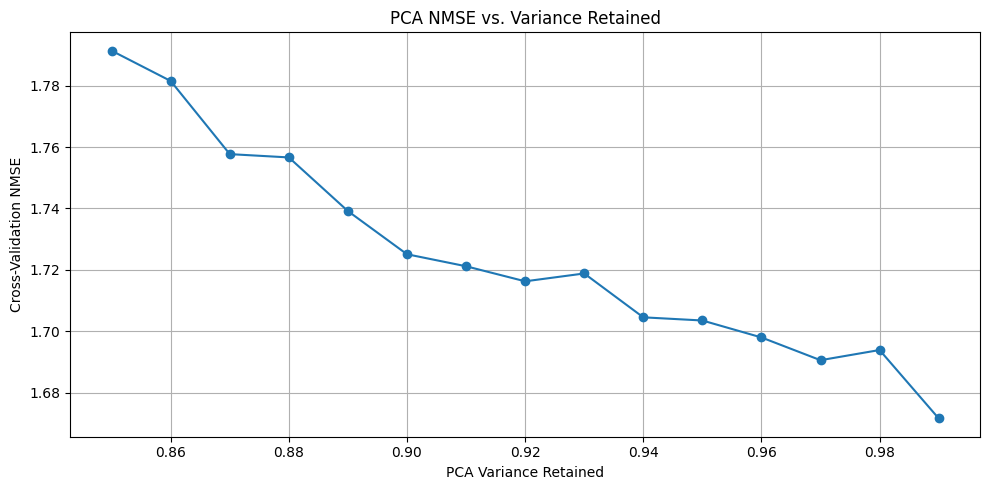

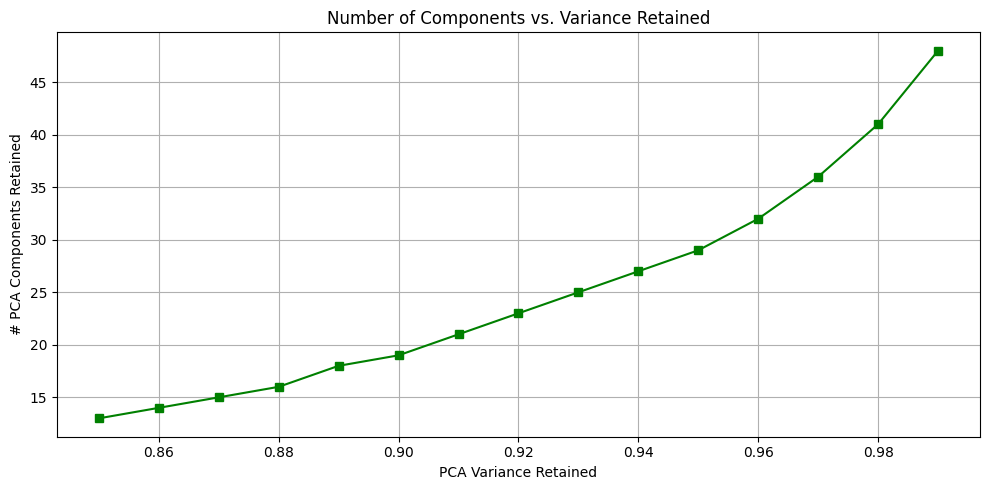

In [82]:
# Prepare inputs
n_sessions, n_windows, n_channels, window_size = X_train_val_folds.shape
X_sessions = X_train_val_folds  # shape: (5, 919, 8, 500)
Y_sessions = Y_train_val_folds  # shape: (5, 919, 51)

# Sweep PCA variance thresholds
variance_thresholds = np.arange(0.85, 0.991, 0.01)
nmse_scores = []
n_components_used = []

for var in variance_thresholds:
    pipeline = Pipeline([
        ('td_feat', TimeDomainTransformer()),  # apply TD features
        ('scale', StandardScaler()),
        ('pca', PCA(n_components=float(var))),
        ('reg', KernelRidge())
    ])

    metric_fns = {'NMSE': NMSE}
    results = cross_validate_pipeline(
        pipeline,
        X_sessions,
        Y_sessions,
        metric_fns=metric_fns,
        n_folds=n_sessions,
        verbose=0
    )

    # Fit once to extract # of components
    pipeline.fit(X_sessions.reshape(-1, n_channels, window_size), Y_sessions.reshape(-1, 51))
    n_comp = pipeline.named_steps['pca'].n_components_

    nmse_scores.append(results['avg_val_NMSE'])
    n_components_used.append(n_comp)

    print(f"Variance: {var:.2f}, NMSE: {results['avg_val_NMSE']:.4f}, Components: {n_comp}")

# Plot NMSE vs. variance retained
plt.figure(figsize=(10, 5))
plt.plot(variance_thresholds, nmse_scores, marker='o')
plt.xlabel("PCA Variance Retained")
plt.ylabel("Cross-Validation NMSE")
plt.title("PCA NMSE vs. Variance Retained")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot #components vs. variance
plt.figure(figsize=(10, 5))
plt.plot(variance_thresholds, n_components_used, marker='s', color='green')
plt.xlabel("PCA Variance Retained")
plt.ylabel("# PCA Components Retained")
plt.title("Number of Components vs. Variance Retained")
plt.grid(True)
plt.tight_layout()
plt.show()

Selected metric: RMS (val NMSE = 1.9808)
Selected metric: MFL (val NMSE = 1.9247)
Selected metric: STD (val NMSE = 1.8667)
Selected metric: ZC (val NMSE = 1.7966)
Selected metric: WA (val NMSE = 1.8940)
Selected metric: VAR (val NMSE = 1.8984)
Selected metric: MPR (val NMSE = 1.8386)
Selected metric: KRT (val NMSE = 1.8185)
Selected metric: MAV (val NMSE = 1.8340)
Selected metric: MAA (val NMSE = 1.8436)
Selected metric: SSC (val NMSE = 1.8533)
Selected metric: WL (val NMSE = 1.8563)


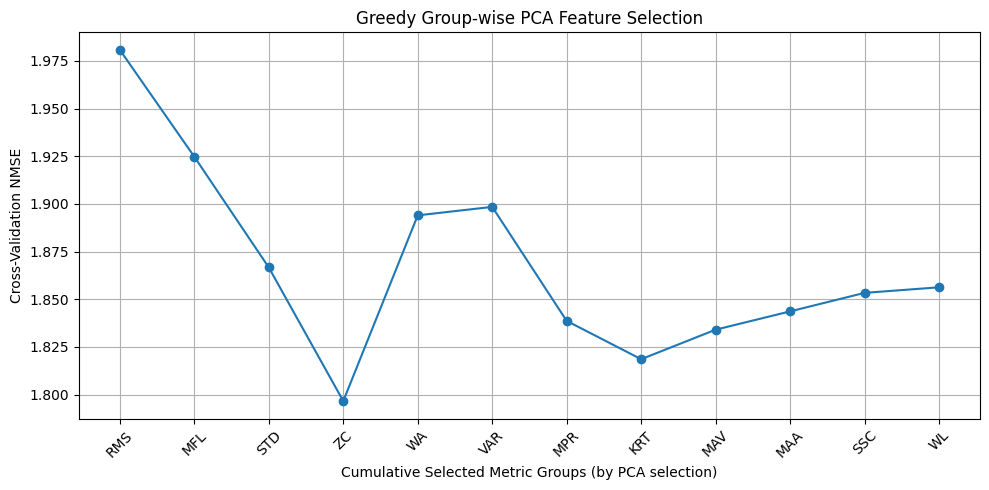

In [75]:
class PCAFeatureReducer(BaseEstimator, TransformerMixin):
    def __init__(self, n_components):
        self.n_components = n_components
        self.pca = PCA(n_components=n_components)
    def fit(self, X, y=None):
        if X.ndim == 3:
            X = X.reshape(-1, X.shape[-1])
        self.pca.fit(X)
        return self
    def transform(self, X):
        if X.ndim == 3:
            X = X.reshape(-1, X.shape[-1])
        return self.pca.transform(X)

# Time-domain feature setup
td_feature_names = ['MAV', 'RMS', 'VAR', 'STD', 'ZC', 'MPR',
                    'MAA', 'WL', 'SSC', 'WA', 'MFL', 'KRT']
n_td_features = len(td_feature_names)
n_sessions, n_windows, n_channels, window_size = X_train_val_folds.shape
n_features = n_channels * n_td_features

# Apply transformer
X_flat = X_train_val_folds.reshape(-1, n_channels, window_size)
td_transformer = TimeDomainTransformer()
X_feat = td_transformer.transform(X_flat).reshape(-1, n_features)
X_sessions = X_feat.reshape(n_sessions, n_windows, n_features)
Y_sessions = Y_train_val_folds

# Metric group index mapping (metric-major layout)
metric_to_indices = {
    metric: list(range(i * n_channels, (i + 1) * n_channels))
    for i, metric in enumerate(td_feature_names)
}

remaining_metrics = list(td_feature_names)
selected_metrics = []
selected_feature_indices = []
CV_err_pca_group = []

# Greedy PCA-based selection
while remaining_metrics:
    best_metric = None
    best_score = np.inf  # lower NMSE is better

    for metric in remaining_metrics:
        candidate_indices = metric_to_indices[metric]
        all_indices = selected_feature_indices + candidate_indices

        pipeline = Pipeline([
            ('select', FeatureSelector(all_indices)),
            # ('scale', StandardScaler()),
            ('pca', PCAFeatureReducer(n_components=min(len(all_indices), 10))),
            ('reg', KernelRidge())
        ])
        metric_fns = {'NMSE': NMSE}
        results = cross_validate_pipeline(
            pipeline,
            X_sessions,
            Y_sessions,
            metric_fns=metric_fns,
            n_folds=n_sessions,
            verbose=0
        )
        avg_nmse = results['avg_val_NMSE']

        if avg_nmse < best_score:
            best_score = avg_nmse
            best_metric = metric
        
    # Add the selected metric group
    print(f"Selected metric: {best_metric} (val NMSE = {best_score:.4f})")
    selected_metrics.append(best_metric)
    selected_feature_indices.extend(metric_to_indices[best_metric])
    remaining_metrics.remove(best_metric)
    CV_err_pca_group.append(best_score)

# Plot NMSE over selected metrics
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(CV_err_pca_group) + 1), CV_err_pca_group, marker='o')
plt.xticks(range(1, len(selected_metrics) + 1), selected_metrics, rotation=45)
plt.xlabel("Cumulative Selected Metric Groups (by PCA selection)")
plt.ylabel("Cross-Validation NMSE")
plt.title("Greedy Group-wise PCA Feature Selection")
plt.grid(True)
plt.tight_layout()
plt.show()

### Riemannian geometry pipelines

In [20]:
import pyriemann
import pyriemann.regression
from sklearn.multioutput import MultiOutputRegressor

In [21]:
# Riemannian geometry of covariance matrices
riem1 = Pipeline(
    [
        ('feature_extraction', pyriemann.estimation.Covariances()),
        ('transformation', pyriemann.tangentspace.TangentSpace(
            metric = 'riemann',
            tsupdate = True)),
        ('regressor', KernelRidge(
            kernel='laplacian'))
    ]
)

riem2 = Pipeline(
    [
        ('feature_extraction', pyriemann.estimation.Covariances()),
        ('transformation', pyriemann.tangentspace.TangentSpace(
            metric = 'riemann',
            tsupdate = True)),
        ('regressor', KNeighborsRegressor())
    ]
)

riem3 = Pipeline(
    [
        ('feature_extraction', pyriemann.estimation.Covariances()),
        ('transformation', pyriemann.tangentspace.TangentSpace(
            metric = 'riemann',
            tsupdate = True)),
        ('regressor', RandomForestRegressor())
    ]
)

In [24]:
# Evaluation
metric_fns = {'RMSE': RMSE, 'NMSE': NMSE}
models = {
    'Riemann + Kernel Ridge': riem1,
    'Riemann + KNN': riem2,
    'Riemann + Random Forest': riem3
}

for model_name, model in models.items():
    print(f'\nModel: {model_name}')
    result = cross_validate_pipeline(model, X_train_val_folds, Y_train_val_folds, metric_fns, verbose=1)


Model: Riemann + Kernel Ridge

Average Scores across folds:
RMSE: train=4.1274, val=5.6207
NMSE: train=0.0848, val=0.1591

Model: Riemann + KNN

Average Scores across folds:
RMSE: train=2.1140, val=5.1833
NMSE: train=0.0223, val=0.1358

Model: Riemann + Random Forest

Average Scores across folds:
RMSE: train=1.3251, val=4.9036
NMSE: train=0.0087, val=0.1230


#### Features selection

### Ensemble regressors

In [ ]:
from ensemble import VotingRegressor

ensemble_estimator = VotingRegressor(
    estimators = [baseline2, riem2]
)

result = cross_validate_pipeline(ensemble_estimator, X_train_val_folds, Y_train_val_folds, metric_fns, verbose=2)

### Estimator validation

### Visualizing predictions to unseen data

In [ ]:
X_train_val_flat = X_train_val_folds.reshape(-1, *X_train_val_folds.shape[2:])
Y_train_val_flat = Y_train_val_folds.reshape(-1, *Y_train_val_folds.shape[2:])

model = ensemble_estimator

model.fit(X_train_val_flat, Y_train_val_flat)
Y_train_pred = model.predict(X_train_val_flat)
Y_test_pred = model.predict(X_test)

print(f"train RMSE:\t{RMSE(Y_train_pred, Y_train_val_flat):.4f}\ttrain NMSE:\t{NMSE(Y_train_pred, Y_train_val_flat):.4f}")
print(f"test RMSE:\t{RMSE(Y_test_pred, Y_test):.4f}\ttest NMSE:\t{NMSE(Y_test_pred, Y_test):.4f}")

In [ ]:
from visualization_tools import scatter_3d_points

bone = 6
Y_true_bone = Y_test[:,3*bone:3*(bone+1)]
Y_pred_bone = Y_test_pred[:,3*bone:3*(bone+1)]

print(f'RMSE for bone {bone}:', RMSE(Y_pred_bone, Y_true_bone))
print(f'NMSE for bone {bone}:', NMSE(Y_pred_bone, Y_true_bone))

ax = scatter_3d_points(Y_true_bone, color = 'b')
scatter_3d_points(Y_pred_bone, color = 'r', ax = ax)
# ax.set_xlim3d(-50, 50)
# ax.set_ylim3d(-50, 50)
# ax.set_zlim3d(-50, 50)
plt.show()